In [1]:
!pip install pmdarima --quiet

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

warnings.filterwarnings('ignore')

In [3]:
ciudad = pd.read_csv('ciudad_barrios.csv')

<div <div class="alert alert-info" role="alert">
    Conteo de barrios
</div>

In [4]:
conteo = ciudad.groupby('BARRIO').count()['geometry'].sort_values( ascending = False)
conteo.head(10)

BARRIO
PALERMO        3323
RECOLETA       1900
SAN NICOLAS    1856
BALVANERA       954
RETIRO          816
FLORES          652
MONSERRAT       587
BELGRANO        557
COLEGIALES      450
CABALLITO       400
Name: geometry, dtype: int64

<div <div class="alert alert-info" role="alert">
    top 5 barrios:
</div>

In [5]:
top_barrios = conteo.index[:5]
top_barrios

Index(['PALERMO', 'RECOLETA', 'SAN NICOLAS', 'BALVANERA', 'RETIRO'], dtype='object', name='BARRIO')

----------

<div <div class="alert alert-info" role="alert">
    desglosando los tiempos
</div>

In [6]:
ciudad['timestamp'] = pd.to_datetime(ciudad['timestamp'])

In [10]:
ciudad['hour'] = ciudad['timestamp'].dt.hour
ciudad['month_number'] = ciudad.timestamp.dt.month
ciudad['month_name'] = ciudad.timestamp.dt.month_name()
ciudad['weekday'] = ciudad.timestamp.dt.weekday
ciudad['weekday_name'] = ciudad.timestamp.dt.day_name()

# Vamos a elegir Palermo (barrio con más casos) como ejemplo

In [53]:
palermo = ciudad[ciudad['BARRIO'] == 'PALERMO']

<div class="alert alert-success" role="alert">
    <p>Vamos a analizar:</p>
    <p><strong>el comportamiento temporal en una serie de tiempo, a ver si se pueden sacar conclusiones y hacer alguna separación (como por motor de búsqueda)</strong></p>
    <p><strong>la distribución de las ocurrencias de búsqueda por hora</strong></p>
</div>

# serie temporal de palermo

In [54]:
palermo = ciudad [ ciudad['BARRIO'] == 'PALERMO' ]

In [56]:
palermo.columns

Index(['Unnamed: 0', 'arrive', 'search_method', 'leave', 'search_longitude',
       'search_latitude', 'uid', 'timestamp', 'geometry', 'BARRIO', 'hour',
       'month_number', 'month_name', 'weekday', 'weekday_name'],
      dtype='object')

In [57]:
#hagamos algún análisis rápido

In [55]:
palermo.groupby('search_method').count()['hour']

search_method
google               662
searchInThisArea     948
startup             1096
this_area            246
updateTimeHome       126
updateVehicle          9
update_time_home     225
update_vehicle        11
Name: hour, dtype: int64

<AxesSubplot:xlabel='DayOfWeek', ylabel='Density'>

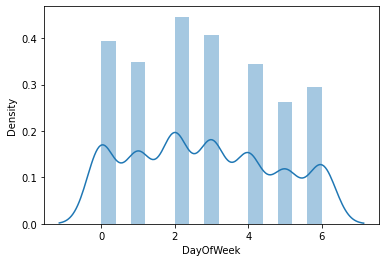

In [58]:
sns.distplot(palermo.weekday, axlabel = 'DayOfWeek')

<div <div class="alert alert-danger" role="alert">
    vamos a desglosar el timestamp para tener una mejor precisión
    y <strong>REDONDEAR LAS HORAS </strong>
    <hr>
    <p>Si una búsqueda a las 6 se da antes de las 6.30, lo redondeo a las 6, </p>
    <p> Si es después de 6.30 lo redondeo a las 7</p>
    
    
</div>
<a href = 'https://stackoverflow.com/questions/5476065/how-to-truncate-the-time-on-a-datetime-object-in-python'>link a la documentacion que encontré </a>

## ejemplo

In [59]:
import datetime

fecha = palermo.timestamp.iloc[0]
fecha #elegimos una fecha para el ejemplo

Timestamp('2021-02-04 16:00:00')

In [60]:
datetime.datetime(fecha.year, fecha.month, fecha.day,fecha.hour) #y la armamos así!

datetime.datetime(2021, 2, 4, 16, 0)

## volviendo a la conversión y redondeo:

In [61]:
#armemos nuestra nueva columna con data prefabricada para plotear una serie temporallll

In [62]:
fecha = palermo.timestamp.iloc[0]
fecha #está a 56 minutos, redondealo! 

Timestamp('2021-02-04 16:00:00')

In [63]:
def redondeador(fecha):
    if fecha.minute < 30:    
        nueva = lambda x : datetime.datetime(x.year, x.month, x.day,x.hour) 
        return nueva(fecha) #si dura menos de 30 minutos lo redondeo a esa hora
    else:
        if fecha.hour != 23:
            nueva = lambda x : datetime.datetime(x.year, x.month, x.day ,x.hour+1)
            return nueva(fecha) #si es mas de 30 lo redondeo para arriba
        else:
            nueva = lambda x : datetime.datetime(x.year, x.month, x.day ,x.hour)
            return nueva(fecha) #salvo que la hora ya sean las 23, sino lo dejo así
            #sino se re complicaba porque tenía que repropagar todo
            
redondeador(fecha)

datetime.datetime(2021, 2, 4, 16, 0)

In [64]:
ciudad.timestamp = ciudad.timestamp.dropna().map(lambda x : redondeador(x))#DROPEA LOS NAS y aplica

In [65]:
palermo = ciudad[ciudad['BARRIO'] == 'PALERMO']
palermo.head(3)

,Unnamed: 0,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp,geometry,BARRIO,hour,month_number,month_name,weekday,weekday_name
7911,7911,2021-02-04 16:00:36,startup,2021-02-04 17:00:36,-58.419543,-34.575729,unauthenticated,2021-02-04 16:00:00,POINT (-58.4195432124275 -34.57572915211439),PALERMO,15.0,2.0,February,3.0,Thursday
7912,7912,2021-01-12 10:30:04,startup,2021-01-12 11:30:04,-58.414274,-34.581036,unauthenticated,2021-01-12 10:00:00,POINT (-58.41427410222759 -34.5810360932697),PALERMO,10.0,1.0,January,1.0,Tuesday
7913,7913,2021-02-05 08:30:35,startup,2021-02-05 09:30:35,-58.433503,-34.577048,unauthenticated,2021-02-05 08:00:00,POINT (-58.4335031 -34.5770481),PALERMO,8.0,2.0,February,4.0,Friday


In [66]:
palermo_timeseries = palermo.sort_values(by='timestamp').groupby('timestamp').count().hour
palermo_timeseries

timestamp
2020-09-06 18:00:00     1
2020-09-07 07:00:00     1
2020-09-07 09:00:00     1
2020-09-07 18:00:00     3
2020-09-10 03:00:00     1
                       ..
2021-03-28 17:00:00     1
2021-03-28 18:00:00     8
2021-03-28 19:00:00     4
2021-03-28 22:00:00     3
2021-03-29 01:00:00    10
Name: hour, Length: 1072, dtype: int64

<div <div class="alert alert-success" role="alert">
    Y, al fin conseguimos nuestro time series
</div>

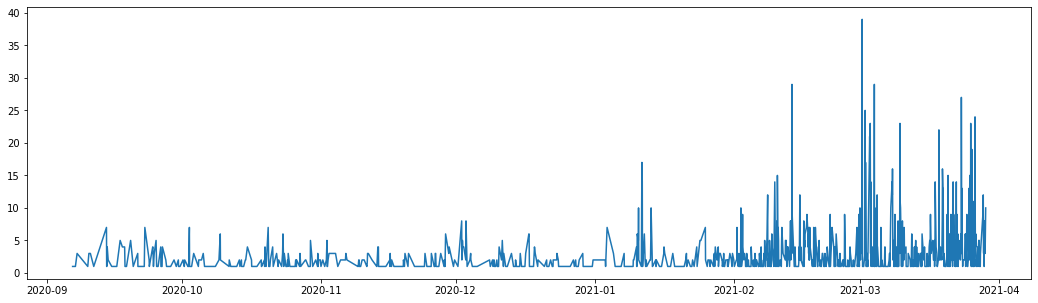

In [67]:
plt.figure(figsize=(18,5))
plt.plot(palermo_timeseries);

Alternativa

import plotly.graph_objects as go
serie_palermo = go.Scatter(x = palermo_timeseries.index, y = palermo_timeseries,
                          hoverinfo= 'y', )

time = go.Figure(serie_palermo)
time.update_xaxes(
    tickformat="%b\n%Y")
time.show()

**hagamos un zoom** : busquemos los valores post 2021

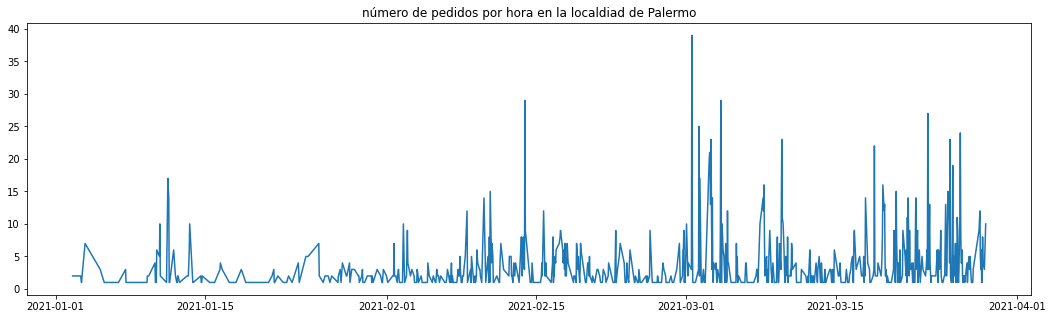

podemos concluir en que hay data mucho más rica a partir de 2021
podemos calcular el número de casos por hora sobre el total, y así sacar una probabilidad horaria


In [68]:
cond_year = palermo_timeseries.index.year == 2021
plt.figure(figsize=(18,5))
plt.plot(palermo_timeseries[cond_year]);
plt.title('número de pedidos por hora en la localdiad de Palermo')
plt.show()
print('podemos concluir en que hay data mucho más rica a partir de 2021')
print('podemos calcular el número de casos por hora sobre el total, y así sacar una probabilidad horaria')

<div class="alert alert-success" role="alert">
    <p><strong>Podemos concluir que</strong></p>
    <p>Como era de esperar, la demanda aumentó muchísimo a partir de 2021, posiblemente por el fin de la cuarentena</p>
    <p>Posiblemente también por un aumento en la popularidad de la app </p>
</div>

# Separemos la data por búsqueda

In [69]:
print(palermo.search_method.unique(),'\n')
print('podemos ver que ay varios términos que se parecen')


['startup' 'searchInThisArea' 'this_area' 'updateTimeHome' 'google'
 'update_time_home' 'update_vehicle' 'updateVehicle'] 

podemos ver que ay varios términos que se parecen


>startup se refiere a cuando arrancan la app, sin realizar una búsqueda:podríamos **dropear startup**


>google se refiere a búsquedas desde google! **conservamos google**

> 'update_time_home' y 'updateTimeHome' son lo mismo, **unifiquemos**

>**lo mismo** con 'update_vehicle' y 'updateVehicle'

>**lo mismo** con 'searchInThisArea' 'this_area'

<div <div class="alert alert-warning" role="alert">
veamos primero la distribución para saber si conviene dropear los valores con startup!

In [70]:
conteo_search_ciudad = ciudad.groupby('search_method').count().hour.sort_values(ascending=False)
conteo_startup_ciudad = conteo_search_ciudad[1]
conteo_search_ciudad

search_method
searchInThisArea    4519
startup             3342
google              2897
this_area           1247
updateTimeHome      1009
update_time_home     826
updateVehicle         79
update_vehicle        49
Name: hour, dtype: int64

In [33]:
print(f'podemos ver que startup tiene {conteo_startup_ciudad} conteos, siendo un {round(conteo_startup_ciudad/len(ciudad)*100)}%')
print('\n',f'nos quedaría un total de {len(ciudad) - conteo_startup_ciudad} entradas en toda la ciudad')
print('\n','podría ser un problema dependiendo los barrios!')

podemos ver que startup tiene 3342 conteos, siendo un 24%

 nos quedaría un total de 10627 entradas en toda la ciudad

 podría ser un problema dependiendo los barrios!


<div class="alert alert-warning" role="alert">
<hr>
     veamos la distribución en el ejemplo de Palermo, para saber si es un problema salvable
</div>

In [34]:
conteo_search_palermo = palermo.groupby('search_method').count().hour.sort_values(ascending=False)
conteo_startup_palermo = conteo_search_palermo[0]
conteo_search_palermo

search_method
startup             1096
searchInThisArea     948
google               662
this_area            246
update_time_home     225
updateTimeHome       126
update_vehicle        11
updateVehicle          9
Name: hour, dtype: int64

In [35]:
print(f'podemos ver que startup tiene {conteo_startup_palermo} conteos, siendo un {round(conteo_startup_palermo/len(palermo)*100)}%')
print('\n',f'nos quedaría un total de {len(palermo) - conteo_startup_palermo} entradas en toda la ciudad')

podemos ver que startup tiene 1096 conteos, siendo un 33%

 nos quedaría un total de 2227 entradas en toda la ciudad


<div class="alert alert-danger" role="alert">
     es un número bastante grande, así que <strong>probemos</strong> inicialmente <strong>SIN</strong> los valores.
</div>

In [36]:
def corrector_metodos(fila): #hay 
    if fila == 'startup':
        return np.nan
    elif fila in ['update_time_home', 'updateTimeHome']:
        return 'home'
    elif fila in ['update_vehicle' ,'updateVehicle']:
        return 'vehicle'
    elif fila in ['searchInThisArea' , 'this_area']:
        return 'in area'
    else:
        return fila

In [37]:
palermo.search_method = palermo.search_method.apply(corrector_metodos) #aplico!
palermo.dropna(inplace=True) #dropeo los Nans!

In [38]:
palermo_time_search = palermo.sort_values(by='timestamp').groupby(['search_method','timestamp']).count()
palermo_time_search.head(2)

Unnamed: 0  arrive  leave  \
search_method timestamp                                        
google        2020-09-06 18:00:00           1       1      1   
              2020-09-07 07:00:00           1       1      1   

                                   search_longitude  search_latitude  uid  \
search_method timestamp                                                     
google        2020-09-06 18:00:00                 1                1    1   
              2020-09-07 07:00:00                 1                1    1   

                                   geometry  BARRIO  hour  month_number  \
search_method timestamp                                                   
google        2020-09-06 18:00:00         1       1     1             1   
              2020-09-07 07:00:00         1       1     1             1   

                                   month_name  weekday  weekday_name  
search_method timestamp                                               
google        2020-09-06 18:00:00           1        1             1  
              2020-09-07 07:00:00           1        1             1

In [39]:
palermo_time_search.index.get_level_values('search_method').unique() 
#así saco los índices del primer nivel

#palermo_time_search.index.get_level_values('timestamp').unique()
#así los del segundo nivel, pongo el nombre del índice. solo por motivos didácticos

Index(['google', 'home', 'in area', 'vehicle'], dtype='object', name='search_method')

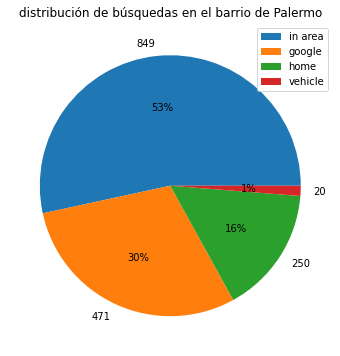

In [40]:
palermocount= palermo.groupby('search_method').count().hour.sort_values(ascending=False)

plt.figure(figsize = (8,6))
plt.pie(palermocount,  labels =palermocount.values , autopct='%.f%%') 
plt.title('distribución de búsquedas en el barrio de Palermo' )
plt.legend(palermocount.index,)
plt.show()

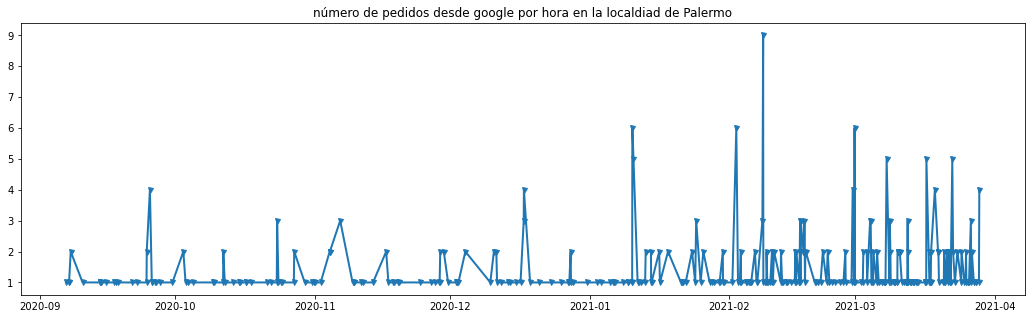

326 ocurrencias en total





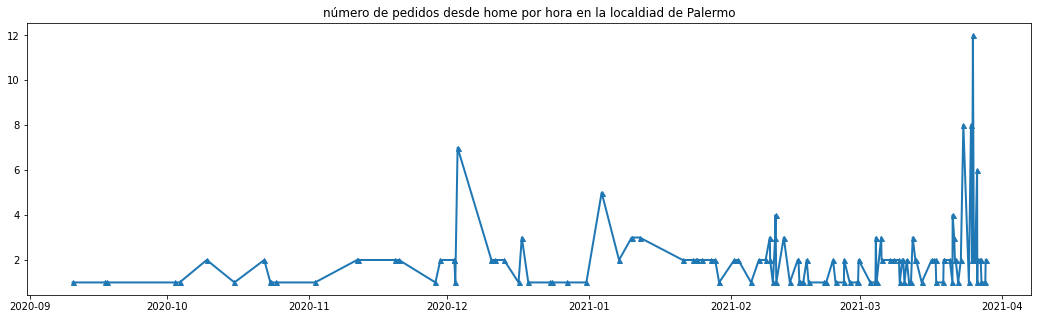

126 ocurrencias en total





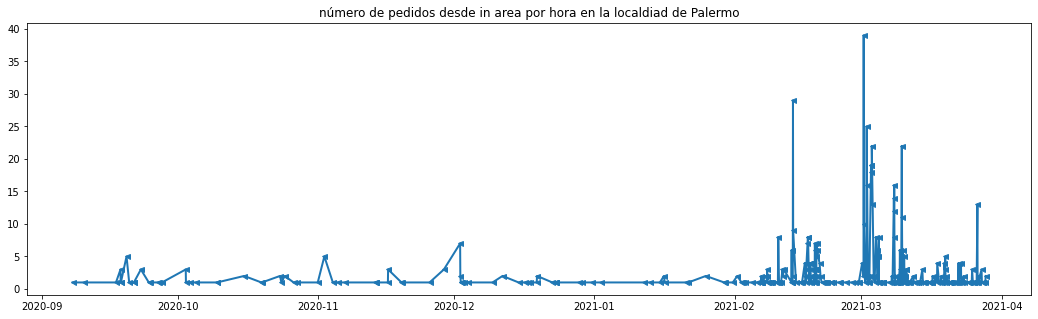

317 ocurrencias en total





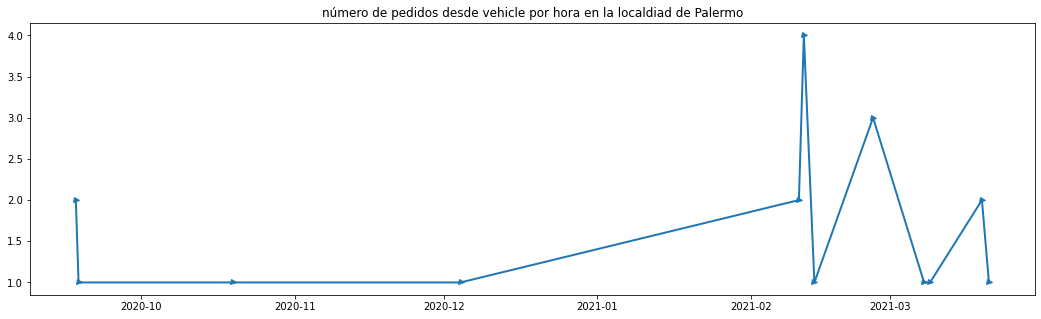

12 ocurrencias en total





In [41]:
indices_palermo = palermo_time_search.index.get_level_values('search_method').unique() 

markers = ["v" , "^" , "<" , ">"]
for j,i in enumerate(indices_palermo):
    #cond_year_search = palermo_time_search.index.year == 2021
    plt.figure(figsize=(18,5))
    
    plt.plot(palermo_time_search.loc[i].hour, f'{markers[j]}-', linewidth=2, markersize=5);
    
    plt.title(f'número de pedidos desde {i} por hora en la localdiad de Palermo')
    plt.show()
    
    print(f'{palermo_time_search.loc[i].hour.count()} ocurrencias en total', 
          end = '\n\n\n\n')

<div class="alert alert-success" role="alert">
    <p><strong>Podemos concluir que</strong></p>
    <p>La verdad, no hay demasiado que pueda concluirse</p>
    <p>Salvo que, nautralmente por la cuarentena en 2020, la mayoría de las búsquedas en ese año se dieron por google.</p>
</div>

# Cálculos de probabilidad por barrio

## distribución de casos por hora en palermo:

### Total de Palermo

In [43]:
dist = palermo.hour.value_counts(normalize=True)
print(dist.head())

14.0    0.071069
13.0    0.067296
5.0     0.064151
12.0    0.061635
17.0    0.059748
Name: hour, dtype: float64


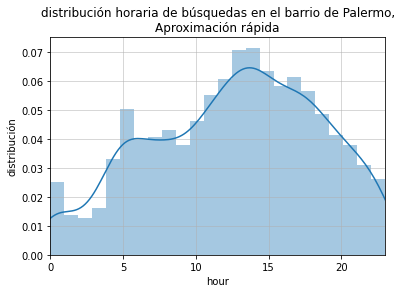

In [71]:
#hagamos una aproximación rápida
sns.distplot(palermo.hour, bins = 24)
plt.title('distribución horaria de búsquedas en el barrio de Palermo,\nAproximación rápida')
plt.xlim(0,23)
plt.grid(lw=0.5), plt.ylabel('distribución') ;

<div class="alert alert-warning" role="alert">
    <p>esto no nos da mucha info!, las probabilidades están muy distribuidas.</p>
    <p><strong>planteemos en grupos horarios!</strong></p>
    <p><strong>Supongamos según el gráfico anterior las siguientes agrupaciones:</strong></p>
    <ol type="A">
      <li>hora a hora (sin modificar ni agregar)</li>
      <li> cada <strong>2</strong> horas</li>
      <li> cada <strong>3</strong> horas</li>
    </ol>
    <hr>
        pd.cut no funciona para nuestros objetivos, así que lo haremos al estilo python clásico

</div>

In [45]:
'''PARA ESO DEFINIMOS ESTA FUNCIÓN DE PARTICIÓN!'''

def agregador(columna, n): #columna a dividir, número de partición
    columna = columna.sort_index()
    valores = [ ( f'{i}-{i+n}' , sum(columna[i:i+n-1]) ) for i in range(0,24,n) ]
    return pd.DataFrame(valores,columns=['horario','probabilidad']).set_index('horario')

<div class="alert alert-info" role="alert">
    A cada hora
    <hr>
</div>

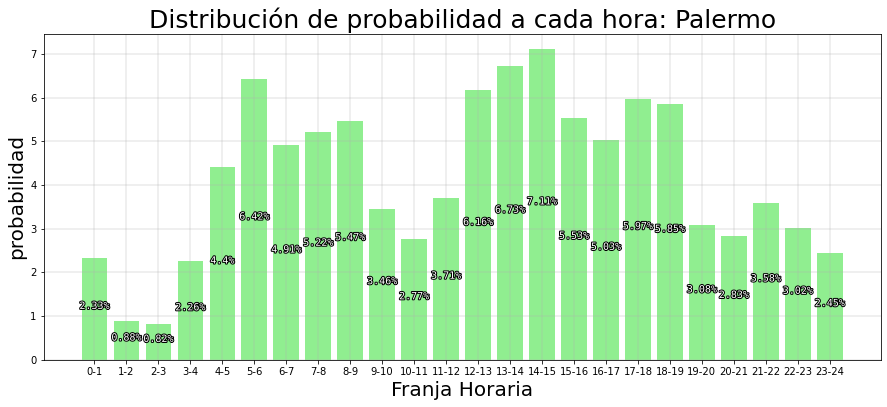

In [46]:
palermo_2h = agregador(dist,1) #ya se, es reiterativo hacer esto. pero lo hacemos para homogeneizar criterios
x = palermo_2h.index
y = palermo_2h.probabilidad
plt.figure(figsize=(15,6))
plt.bar(x ,y*100, color = 'lightgreen')
plt.grid(lw=0.4)
plt.ylabel('probabilidad', fontdict = {'size':20})
plt.xlabel('Franja Horaria', fontdict = {'size':20})
plt.title('Distribución de probabilidad a cada hora: Palermo', fontdict = {'size':25})

font = {'family': 'monospace' ,  'color':  'white',
        'size': 10, 'horizontalalignment':'center'}
for i in range(24):
    plt.text(i, #x
             y[i]*50,
             f'{round(y[i]*100, 2)}%', 
             fontdict=font,
             path_effects=[pe.withStroke(linewidth=2, foreground="black")])

plt.show()

<div class="alert alert-info" role="alert">
    cada 2 horas
    <hr>
</div>

In [47]:
palermo_2h = agregador(dist,2)
palermo_2h.head()

,probabilidad
horario,
0-2,0.032075
2-4,0.030818
4-6,0.108176
6-8,0.101258
8-10,0.089308


[click aquí para las propiedades de texto!](https://matplotlib.org/stable/tutorials/text/text_props.html)

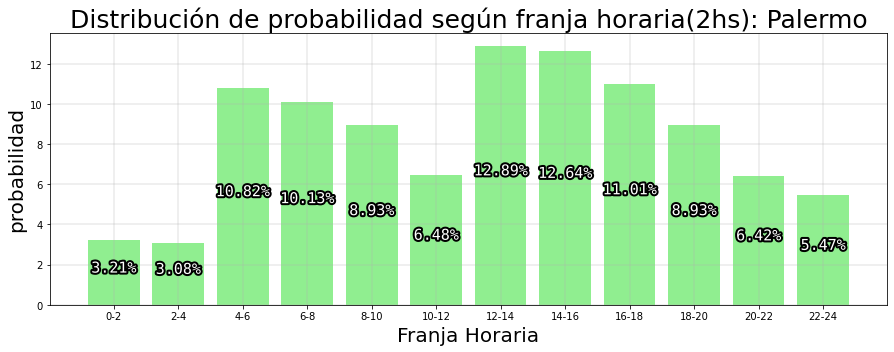

In [48]:
x = palermo_2h.index
y = palermo_2h.probabilidad
plt.figure(figsize=(15,5))
plt.bar(x ,y*100, color = 'lightgreen')
plt.grid(lw=0.4)
plt.ylabel('probabilidad', fontdict = {'size':20})
plt.xlabel('Franja Horaria', fontdict = {'size':20})
plt.title('Distribución de probabilidad según franja horaria(2hs): Palermo', fontdict = {'size':25})
font = {'family': 'monospace' ,  'color':  'white',
        'size': 15, 'horizontalalignment':'center'}
for i in range(12):
    plt.text(i, #x
             y[i]*50,
             f'{round(y[i]*100, 2)}%', 
             fontdict=font,
             path_effects=[pe.withStroke(linewidth=4, foreground="black")])

plt.show()

<div class="alert alert-info" role="alert">
    cada 3 horas
    <hr>
</div>

In [49]:
palermo_3h = agregador(dist,3)
palermo_3h.head()

,probabilidad
horario,
0-3,0.040252
3-6,0.130818
6-9,0.155975
9-12,0.099371
12-15,0.200000


[click aquí para las propiedades de texto!](https://matplotlib.org/stable/tutorials/text/text_props.html)

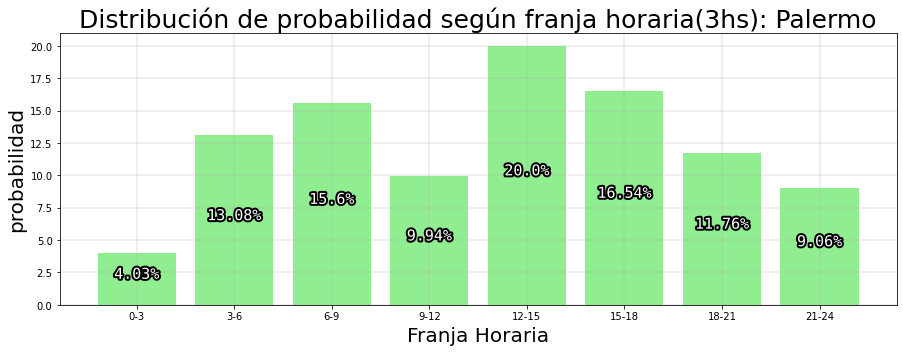

In [50]:
x = palermo_3h.index
y = palermo_3h.probabilidad
plt.figure(figsize=(15,5))
plt.bar(x ,y*100, color = 'lightgreen')
plt.grid(lw=0.4)
plt.ylabel('probabilidad', fontdict = {'size':20})
plt.xlabel('Franja Horaria', fontdict = {'size':20})
plt.title('Distribución de probabilidad según franja horaria(3hs): Palermo', fontdict = {'size':25})
font = {'family': 'monospace' ,  'color':  'white',
        'size': 15, 'horizontalalignment':'center'}
for i in range(8):
    plt.text(i, #x
             y[i]*50,
             f'{round(y[i]*100, 2)}%', 
             fontdict=font,
             path_effects=[pe.withStroke(linewidth=4, foreground="black")])

plt.show()

<div class="alert alert-warning" role="alert">
    Una franja horaria de 3 horas es menos necesario.
    El primer gráfico presenta suficiente info para llegar a conclusiones:
</div>

<div class="alert alert-success" role="alert">
    <p><strong>CONCLUSIONES</strong></p>
    <p>Según lo que parece, <strong> EN GENERAL</strong>, la mayor necesidad de estacionamientos se dan entre las horas tempranas y las horas laborales (posiblemente) posteriores al mediodía</p>
    <p> cuanto más englobo en franjas horarias más anchas, este comportamiento se evidencia graficamente </p>
    <hr>
    <p>hay una mayor probabilidad de búsqueda en la mañana temprana y en horas posteriores al almuerzo </p>
    <p><strong>Analicemos en otra notebook la distribución horaria por día!</strong></p>
</div>

<div class="alert alert-warning" role="alert">
    <p><strong>QUEDA PENDIENTE</strong></p>
    <p>Analizar la misma distribución para cada día!</p>
    <p>analizar y tratar una <strong> serie temporal </strong>, a fines de analizar la posibilidad de pronosticar la demanda en tiempo real</p>
    <hr>
    